<a href="https://colab.research.google.com/github/smontes-fing/UTE_PRESENTACION/blob/main/Generar_estadisticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Instalo dependencias
Instalo las dependencias con sus versiones con las que fueron testeados los scripts .py

In [ ]:
# Instalacion de dependencias
!pip install icecream
!pip install pandas==2.2.2
!pip install tensorflow==2.12
!pip install pillow matplotlib
!pip install netCDF4
!pip install gdown

  Using cached netCDF4-1.7.1.post2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached cftime-1.6.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
Using cached netCDF4-1.7.1.post2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.0 MB)
Using cached cftime-1.6.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


# Cargar dependencias



- Opción 1: subo el archivo zip con las dependecias locales y lo dejo disponible para trabajar
- Opción 2: importo el repositorio github

In [ ]:
# !unzip UTE_presentacion.zip
# #remuevo los archivos que no son necesarios
# !rm -rf __MACOSX
# !rm UTE_presentacion.zip

%cd /content
!rm -rf UTE_PRESENTACION
!git clone https://github.com/smontes-fing/UTE_PRESENTACION.git

/content
Cloning into 'UTE_PRESENTACION'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 112 (delta 4), reused 19 (delta 2), pack-reused 83 (from 1)
Receiving objects: 100% (112/112), 81.14 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (71/71), done.


In [ ]:
# Agregar el path /UTE_PRESENTACION al sys.path de python
import sys
import os

# Agregar el directorio al path
sys.path.append(os.path.abspath('UTE_PRESENTACION/'))

# Verificar que el directorio se haya agregado correctamente
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/UTE_PRESENTACION']


In [ ]:
# Cambiar al directorio UTE_presentacion
os.chdir('UTE_PRESENTACION')

# Verificar que estamos en el directorio correcto
print(os.getcwd())  # Imprime el directorio actual

/content/UTE_PRESENTACION


In [ ]:
# Verifico que estoy en el directorio correcto /content/UTE_PRESENTACION
!pwd

/content/UTE_PRESENTACION


# Genero estadísticas para un escenario
El objetivo es generar estadística en base a un conjunto de años sintéticos de temperatura.



![Pipeline completo del flujo de datos y el modelo](Imagenes_pipeline/DiagramaFlujo-v5.png)

Mediante la técnica de bottom-up se suma a la demanda (*business as usual*) predecida por el modelo para el año en estudio el consumo proyectado para el Driver.  
En este caso se estima como driver la penetración estimada de EVs para un escenario moderado y para el año 2040.

En particular nos vamos a concentrar en la siguiente sección del pipeline

![Descripción de la imagen](Imagenes_pipeline/driver.png)


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from funciones.utils_temp import cargar_datos_temp_sint
from funciones.utils_dem import cargar_datos_dem_sint
from funciones.utils_driverEVs import (
    cargar_datos_EV,
    graficar_curvas_carga_normalizadas,
    EV_consumption_Ener,
    EV_consumption_hh,
    probabilidad_carga_EVs
)
from funciones.utils import (
    def_rango_fecha,
    plot_densidades_escenarios,
    plot_POE
)

from generar_estadisticas import (
    proyeccion_driver_EV,
    plot_datos_semana,
    analizar_demanda)


print(f"TensorFlow version = {tf.__version__}")
print(f"Pandas version = {pd.__version__}")
print(f"Numpy version = {np.__version__}")


TensorFlow version = 2.12.0
Pandas version = 2.2.2
Numpy version = 1.23.5


### Argumentos o parámetros de entrada

Se definen los parámetros con los cuales se va a trabajar. Estos son los argumentos de input que recibe el script *generar_estadisticas.py*.

In [ ]:
year = 2040
demand_path = 'datos/dem_sintetico_100.csv'
curva = 'BaU'
ev_list = []

###Cargo los datos de calendario

Esto se realiza para incorporar el formato de los datos y copiar el formato calendario que contienen los datos de temperatura generados.

In [ ]:
# Carga datos de temperatura
temp_data_path = 'datos/temp_sintetico_2.csv'
temp_data = cargar_datos_temp_sint(temp_data_path)
calendar = temp_data[['DiaSemana', 'Mes', 'Dia', 'Hora']]

###Proyección de demanda

Carga la proyecctión de energía segun PBI hasta 2040, esta es la energía total consumida estimada por el modelo econométrico en base a la proyección del PBI y otros factores.

In [ ]:

# Modelo econométrico
pbi_proyection_path = 'datos/proy_econometrica_PBI.csv'
pbi_proy = pd.read_csv(pbi_proyection_path, engine='pyarrow')
energy_proy = pbi_proy.loc[pbi_proy['ANO'] == year, 'Energia'].iloc[0]
energy_base = pbi_proy.loc[pbi_proy['ANO'] == 2021, 'Energia'].iloc[0]


In [ ]:
print(f"proyección de energía segun PBI para {year} MWh", energy_proy)
print(f"proyección de energía segun PBI para 2021 MWh", energy_base)

proyección de energía segun PBI para 2040 MWh 14978148
proyección de energía segun PBI para 2021 MWh 10671561


##Cargo los datos de demanda
Datos de demanda *as usual* predecida por el modelo

In [ ]:
print(f"Cargando datos de demanda path: {demand_path}")
demand_data = cargar_datos_dem_sint(
                                    demand_path,
                                    energy_proy,
                                    energy_base
                                    )
_, num_years = demand_data.shape

Cargando datos de demanda path: datos/dem_sintetico_100.csv


In [ ]:
print(f"Archivo de datos de demanda contiene {num_years-1} de demanda simulados ")
print(f"Archivo de demanda \n")
print(demand_data.head())

Archivo de datos de demanda contiene 100 de demanda simulados 
Archivo de demanda 

                       0            1            2            3            4  \
0  0.000000  1310.835373  1454.576531  1464.721023  1399.274210  1298.343838   
1  1.403557  1235.421660  1370.229555  1353.993540  1318.599473  1204.086737   
2  2.807115  1174.329636  1329.893899  1250.998817  1255.609012  1157.470386   
3  4.210672  1127.587808  1243.781921  1217.076941  1207.488539  1124.568980   
4  5.614229  1091.987698  1185.540972  1187.519707  1152.712607  1067.186755   

             5            6            7            8  ...           90  \
0  1312.582984  1464.721023  1464.721023  1358.518609  ...  1249.524661   
1  1245.029768  1353.993540  1353.993540  1272.944419  ...  1211.183305   
2  1214.954060  1250.998817  1250.998817  1212.791459  ...  1202.273158   
3  1185.360334  1217.076941  1217.076941  1181.000043  ...  1192.569215   
4  1142.492324  1187.519707  1187.519707  1141.302528  ...  

## Driver EV
Proyección de la demanda que va a consumir el Driver EVs. Se estima el parque vehícular y la forma de la curva de carga en función de una curva de probabilidad de carga y del consumo estimado diario que tienen los distintos tipos de EVs.



In [ ]:
ev_list = []
#ev_list = [0, # Ev light_duty
#           0, # Buses eléctricos
#           0, # EVs Heavy_Duty  (camiones de logística)
#           ]

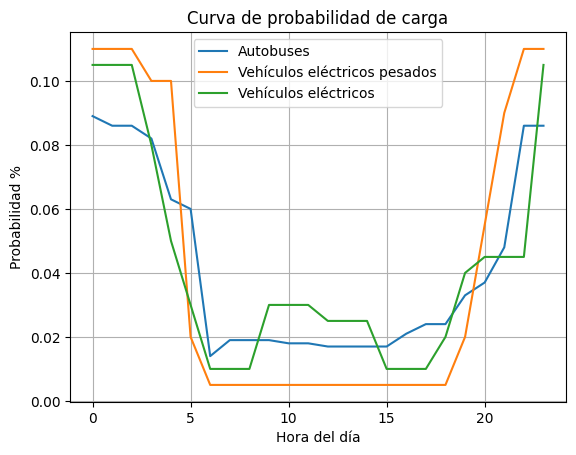

Energía consumida por light-duty evs: 365000.0, % del total de energía consumida: 0.024 %
Energía consumida por buses eléctricos: 138700.0, % del total de energía consumida: 0.009 %
Energía consumida por Heavy-duty evs: 408800.0, % del total de energía consumida: 0.027 %


In [ ]:
# Genera los datos del Driver EV
ev_data, _ = proyeccion_driver_EV(year,
                                  ev_list,
                                  curva,
                                  calendar,
                                  energy_proy
                                  )

In [ ]:
path_figure = f"output/probabilidad_carga_{curva}.png"
print(f"Imagen de Probabilidad de carga {curva} guardada en :\n {path_figure}")

Imagen de Probabilidad de carga BaU guardada en :
 output/probabilidad_carga_BaU.png


# Modelo Bottom_up

In [ ]:
# Merge de los dos dataframes demand_data y ev_data
merged_data = pd.merge(demand_data, ev_data, left_index=True, right_index=True)

In [ ]:
# Muestro una sema especifica del anio con la demanda driver y la proyectada
# Preprocess de los datos de calendario
date_range = def_rango_fecha(str(year))
merged_data.index = date_range
start_date = f'{year}-06-15'
end_date = pd.Timestamp(start_date) + pd.DateOffset(days=7)
if 'Ano' in merged_data.columns:
    year_to_show = f'Ano_{random.randint(0, num_years - 1)}'
else:
    year_to_show = f'{random.randint(0, num_years - 1)}'

print(f"Año a mostrar en la gráfica: {year_to_show}")

Año a mostrar en la gráfica: 23


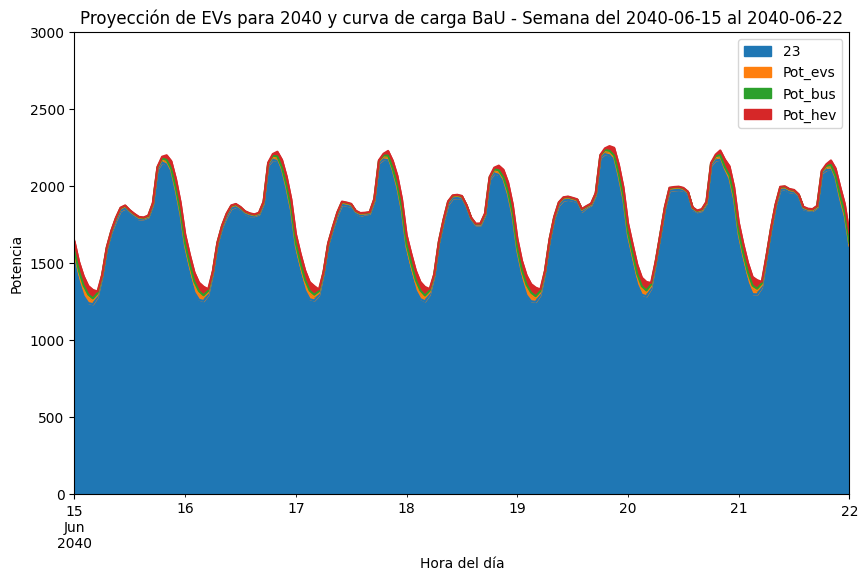

In [ ]:
data_to_show = merged_data[[year_to_show, 'Pot_evs', 'Pot_bus', 'Pot_hev']]
week_data = data_to_show.loc[start_date:end_date]
plot_datos_semana(week_data,
                  start_date,
                  end_date,
                  year,
                  curva)

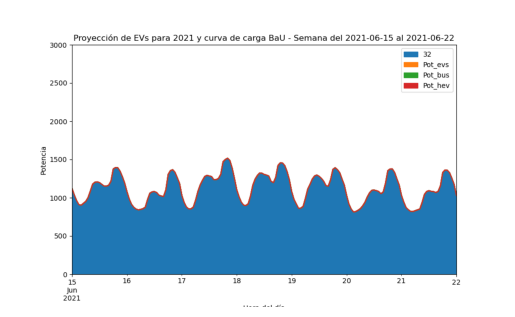

In [ ]:
# Cargar la imagen de un escenario con la demanda as Usual y el consumo de los EVs
image_EV_dem = Image.open(f'output/proy_EV_2021_{curva}.png')
# Mostrar la imagen
plt.imshow(image_EV_dem)
plt.axis('off')  # Opcional, oculta los ejes
plt.show()

##Analisis estadístico

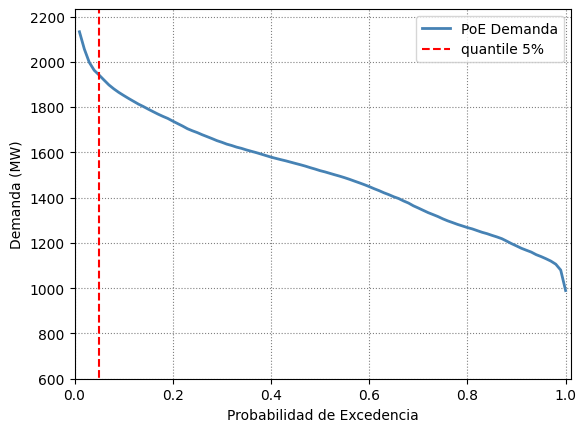

In [ ]:
# Analisis de resultados
PoE_path = f"output/PoE_{curva}_{year}.png"
plot_POE(merged_data[year_to_show], PoE_path) # probabildiad de excedencia


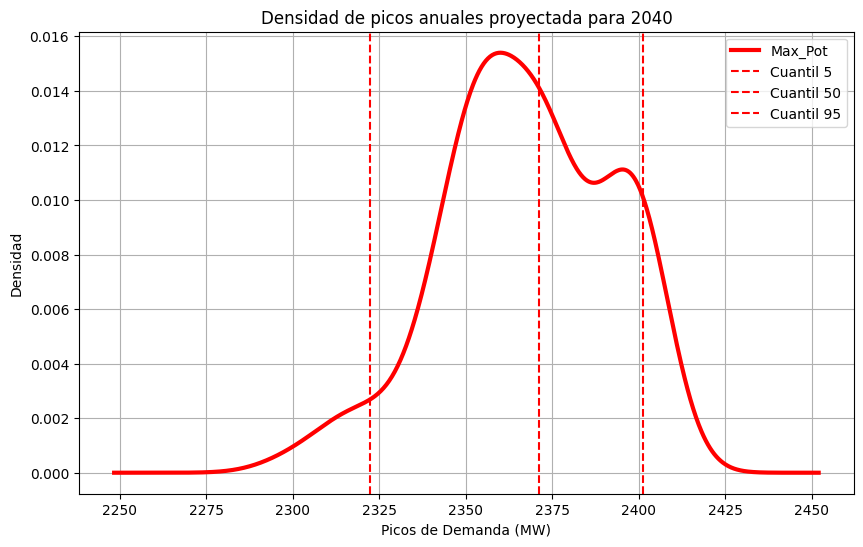

In [ ]:
# analisis de picos anuales
statistics = analizar_demanda(merged_data, num_years)
key = f"{curva}_{year}"
dicc_estadisticas = {key: statistics}
densidades_path = f"output/densidad_de_picos_{year}_{curva}.png"
plot_densidades_escenarios(dicc_estadisticas[key],
                            title= f"Densidad de picos anuales proyectada para {year}",
                            path=densidades_path
                            )

#Comparo con 2021

#Comparo niveles de penetración de EVs